In [99]:
# Basic Libraries 
# --------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import rcParams
import sys

# import matplotlib
#  matplotlib.use("Qt5Agg")
import missingno as msno
from datetime import date
import joblib
import logging
import yellowbrick
from yellowbrick.model_selection import FeatureImportances
import pickle
import optuna
import scipy
import statsmodels.api as sm


# Plotly Express - Plotly - cufflinks 
# --------------------------------------

import cufflinks as cf
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

# Metrics 
# --------------------------------------
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, \
    classification_report, mean_squared_error, mean_absolute_error, r2_score, precision_recall_curve, auc, average_precision_score, roc_curve
from sklearn.neighbors import LocalOutlierFactor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
import optuna
import optuna.logging as optuna_logging
from pandas_profiling import ydata_profiling
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning Models For Regression 
# --------------------------------------
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Machine Learning Models For Classification 
# --------------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, CategoricalNB, ComplementNB


# Remove Warnings
# ------------------------------------------------------------
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 600)
from termcolor import colored

constraints = ['#581845', '#C70039']
metric_constraints = ['#2ECC71', '#34495E', '#D0D3D4']
cat_feat_constraints = ['#7FB3D5', '#76D7C4', '#F7DC6F', '#85929E', '#283747']


In [100]:
df = pd.read_csv("datasets/HousePrice/train.csv").drop("Id", axis=1)
df_test = pd.read_csv("datasets/HousePrice/test.csv").drop("Id", axis=1)

# df = pd.read_csv("datasets/HousePrice/train.csv", index_col="Id")
# df_test = pd.read_csv("datasets/HousePrice/test.csv", index_col="Id")


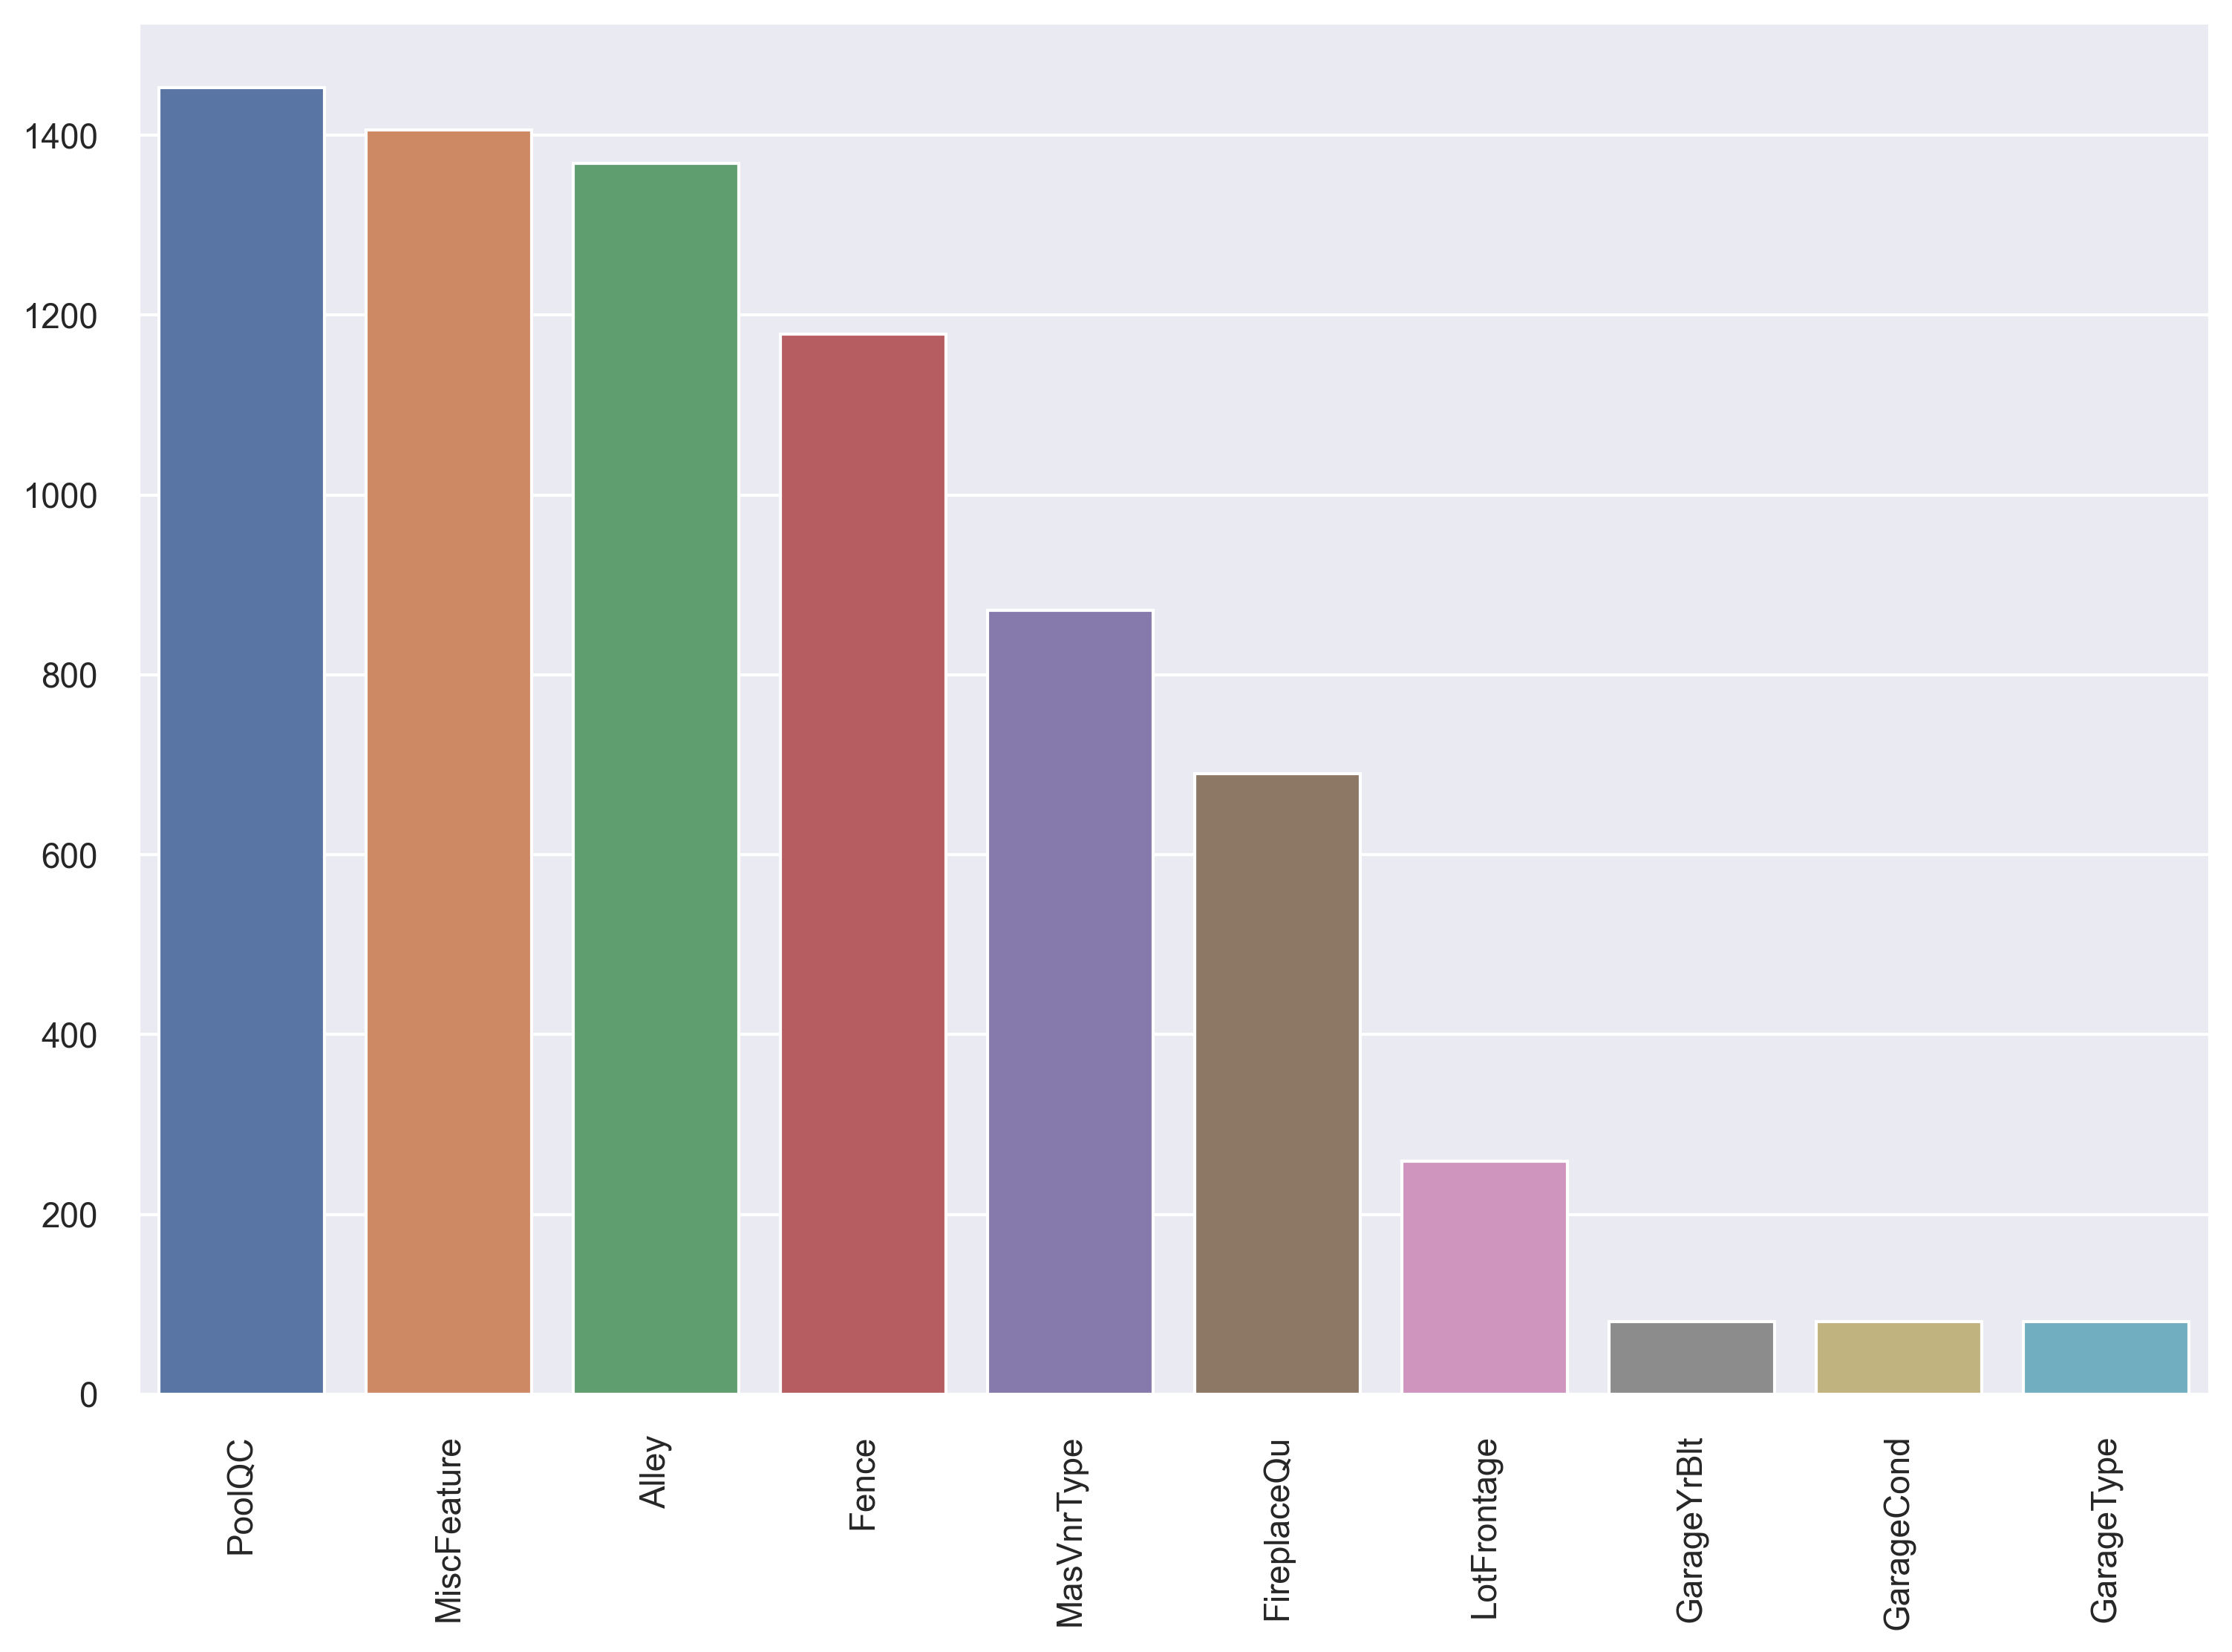

In [101]:
sns.set_theme()
sns.set(rc={'figure.figsize':(12,8), 'figure.dpi':300})
cols_with_null=df.isnull().sum().sort_values(ascending=False).head(10)
sns.barplot(x=cols_with_null.index,y=cols_with_null)
plt.xticks(rotation=90)
plt.show()

In [102]:
cols_to_drop=(cols_with_null.head(6).index).tolist()
df.drop(cols_to_drop,axis=1,inplace=True)

In [103]:
y = df.SalePrice
X = df.drop(['SalePrice'], axis=1)

In [104]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)

In [105]:
print(X_train.shape)
print(X_val.shape)

(1168, 73)
(292, 73)


In [106]:
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ["int", "float", "int32", "float32", "int64",
                                                                "float64"]]
categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and X[cname].dtype == "object"]

In [107]:
print("The total number of categorical columns:", len(categorical_cols))
print("The total number of numerical columns:", len(numerical_cols))

The total number of categorical columns: 34
The total number of numerical columns: 36


In [108]:
my_cols = categorical_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_val= X_val[my_cols].copy()
X_test = df_test[my_cols].copy()

In [109]:
numerical_transformer = Pipeline(steps=[
    ('imputer_num', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer_cat", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

In [110]:
metric_res = []
models = []

models.append(("LGBMRegressor", LGBMRegressor()))
models.append(('XGBRegressor', XGBRegressor()))
models.append(('CatBoostRegressor', CatBoostRegressor(verbose=False, )))
models.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
models.append(('AdaBoostRegressor', AdaBoostRegressor()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor()))
models.append(('LogisticRegression', LogisticRegression()))
models.append(('MLPRegressor', MLPRegressor()))
models.append(('KNeighborsRegressor', KNeighborsRegressor()))


In [111]:
def clc_ml(model):
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)]).fit(X_train, y_train)
    y_pred = my_pipeline.fit(X_train, y_train).predict(X_val)

    r2 = r2_score(y_val, y_pred)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    kfold = KFold(n_splits=5, shuffle=True)
    rmse_cv = np.mean(np.sqrt(-cross_val_score(my_pipeline, X, y, cv=kfold, scoring="neg_mean_squared_error")))
    cv_results = cross_val_score(my_pipeline, X_train, y_train, scoring='r2', cv=kfold)
    cv_mean = cv_results.mean()

    model_results = pd.DataFrame({
        'Model': [name],
        'R2 Score': [r2],
        'R Value': [r_value],
        'Mean Absolute Error': [mae],
        'Root Mean Squared Error': [rmse],
        'Cross Validation RMSE': [rmse_cv],
        'Cross Validation R2 Score': [cv_mean],
    })
    metric_res.append(model_results)


for name, model in models:
    clc_ml(model)

In [117]:
final = pd.concat(metric_res, ignore_index=True)
final.sort_values(by='R2 Score', ascending=False)

,Model,R2 Score,R Value,Mean Absolute Error,Root Mean Squared Error,Cross Validation RMSE,Cross Validation R2 Score
3,GradientBoostingRegressor,0.89251,0.94476,16622.35304,27245.66774,27546.47736,0.85587
2,CatBoostRegressor,0.87832,0.93731,15653.91058,28988.23168,25948.52598,0.86916
1,XGBRegressor,0.87342,0.93554,17696.82446,29566.31384,32635.93566,0.85520
0,LGBMRegressor,0.84492,0.91934,17359.09123,32725.87013,29228.40036,0.87518
5,RandomForestRegressor,0.84126,0.91804,17302.45527,33109.68068,30560.05108,0.86529
4,AdaBoostRegressor,0.74232,0.86967,24554.22569,42184.28428,35254.31159,0.77951
6,DecisionTreeRegressor,0.72236,0.85732,27889.28767,43787.46791,42276.01139,0.70157
9,KNeighborsRegressor,0.64452,0.80525,24508.27397,49547.00153,38163.86036,0.78963
7,LogisticRegression,0.49814,0.71451,31388.08562,58870.94904,47593.85721,0.68268
8,MLPRegressor,-4.37556,0.79969,174713.52734,192672.80826,190030.51445,-5.31015


In [132]:
model = eval(final.sort_values(by='R2 Score', ascending=False).iloc[0, 0] + "()") if final.sort_values(by='R2 Score', ascending=False).iloc[0, 0] != "CatBoostRegressor" else eval(final.sort_values(by='R2 Score', ascending=False).iloc[0, 0] + "(verbose=False)")
final_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)]).fit(X_train, y_train)

In [162]:


# Assuming final_model is a Pipeline containing the GradientBoostingRegressor as the last step
clf = final_model[-1]  # Access the last step in the pipeline

# Get feature importances and feature names
feature_importances = clf.feature_importances_
feature_names = X_train.columns.tolist()  # Assuming X_train is your training data

# Create a pandas dataframe
data = list(zip(feature_names, feature_importances))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
# df_importances.plot(x='Feature', y='Importance', kind='barh', figsize=(12, 8))


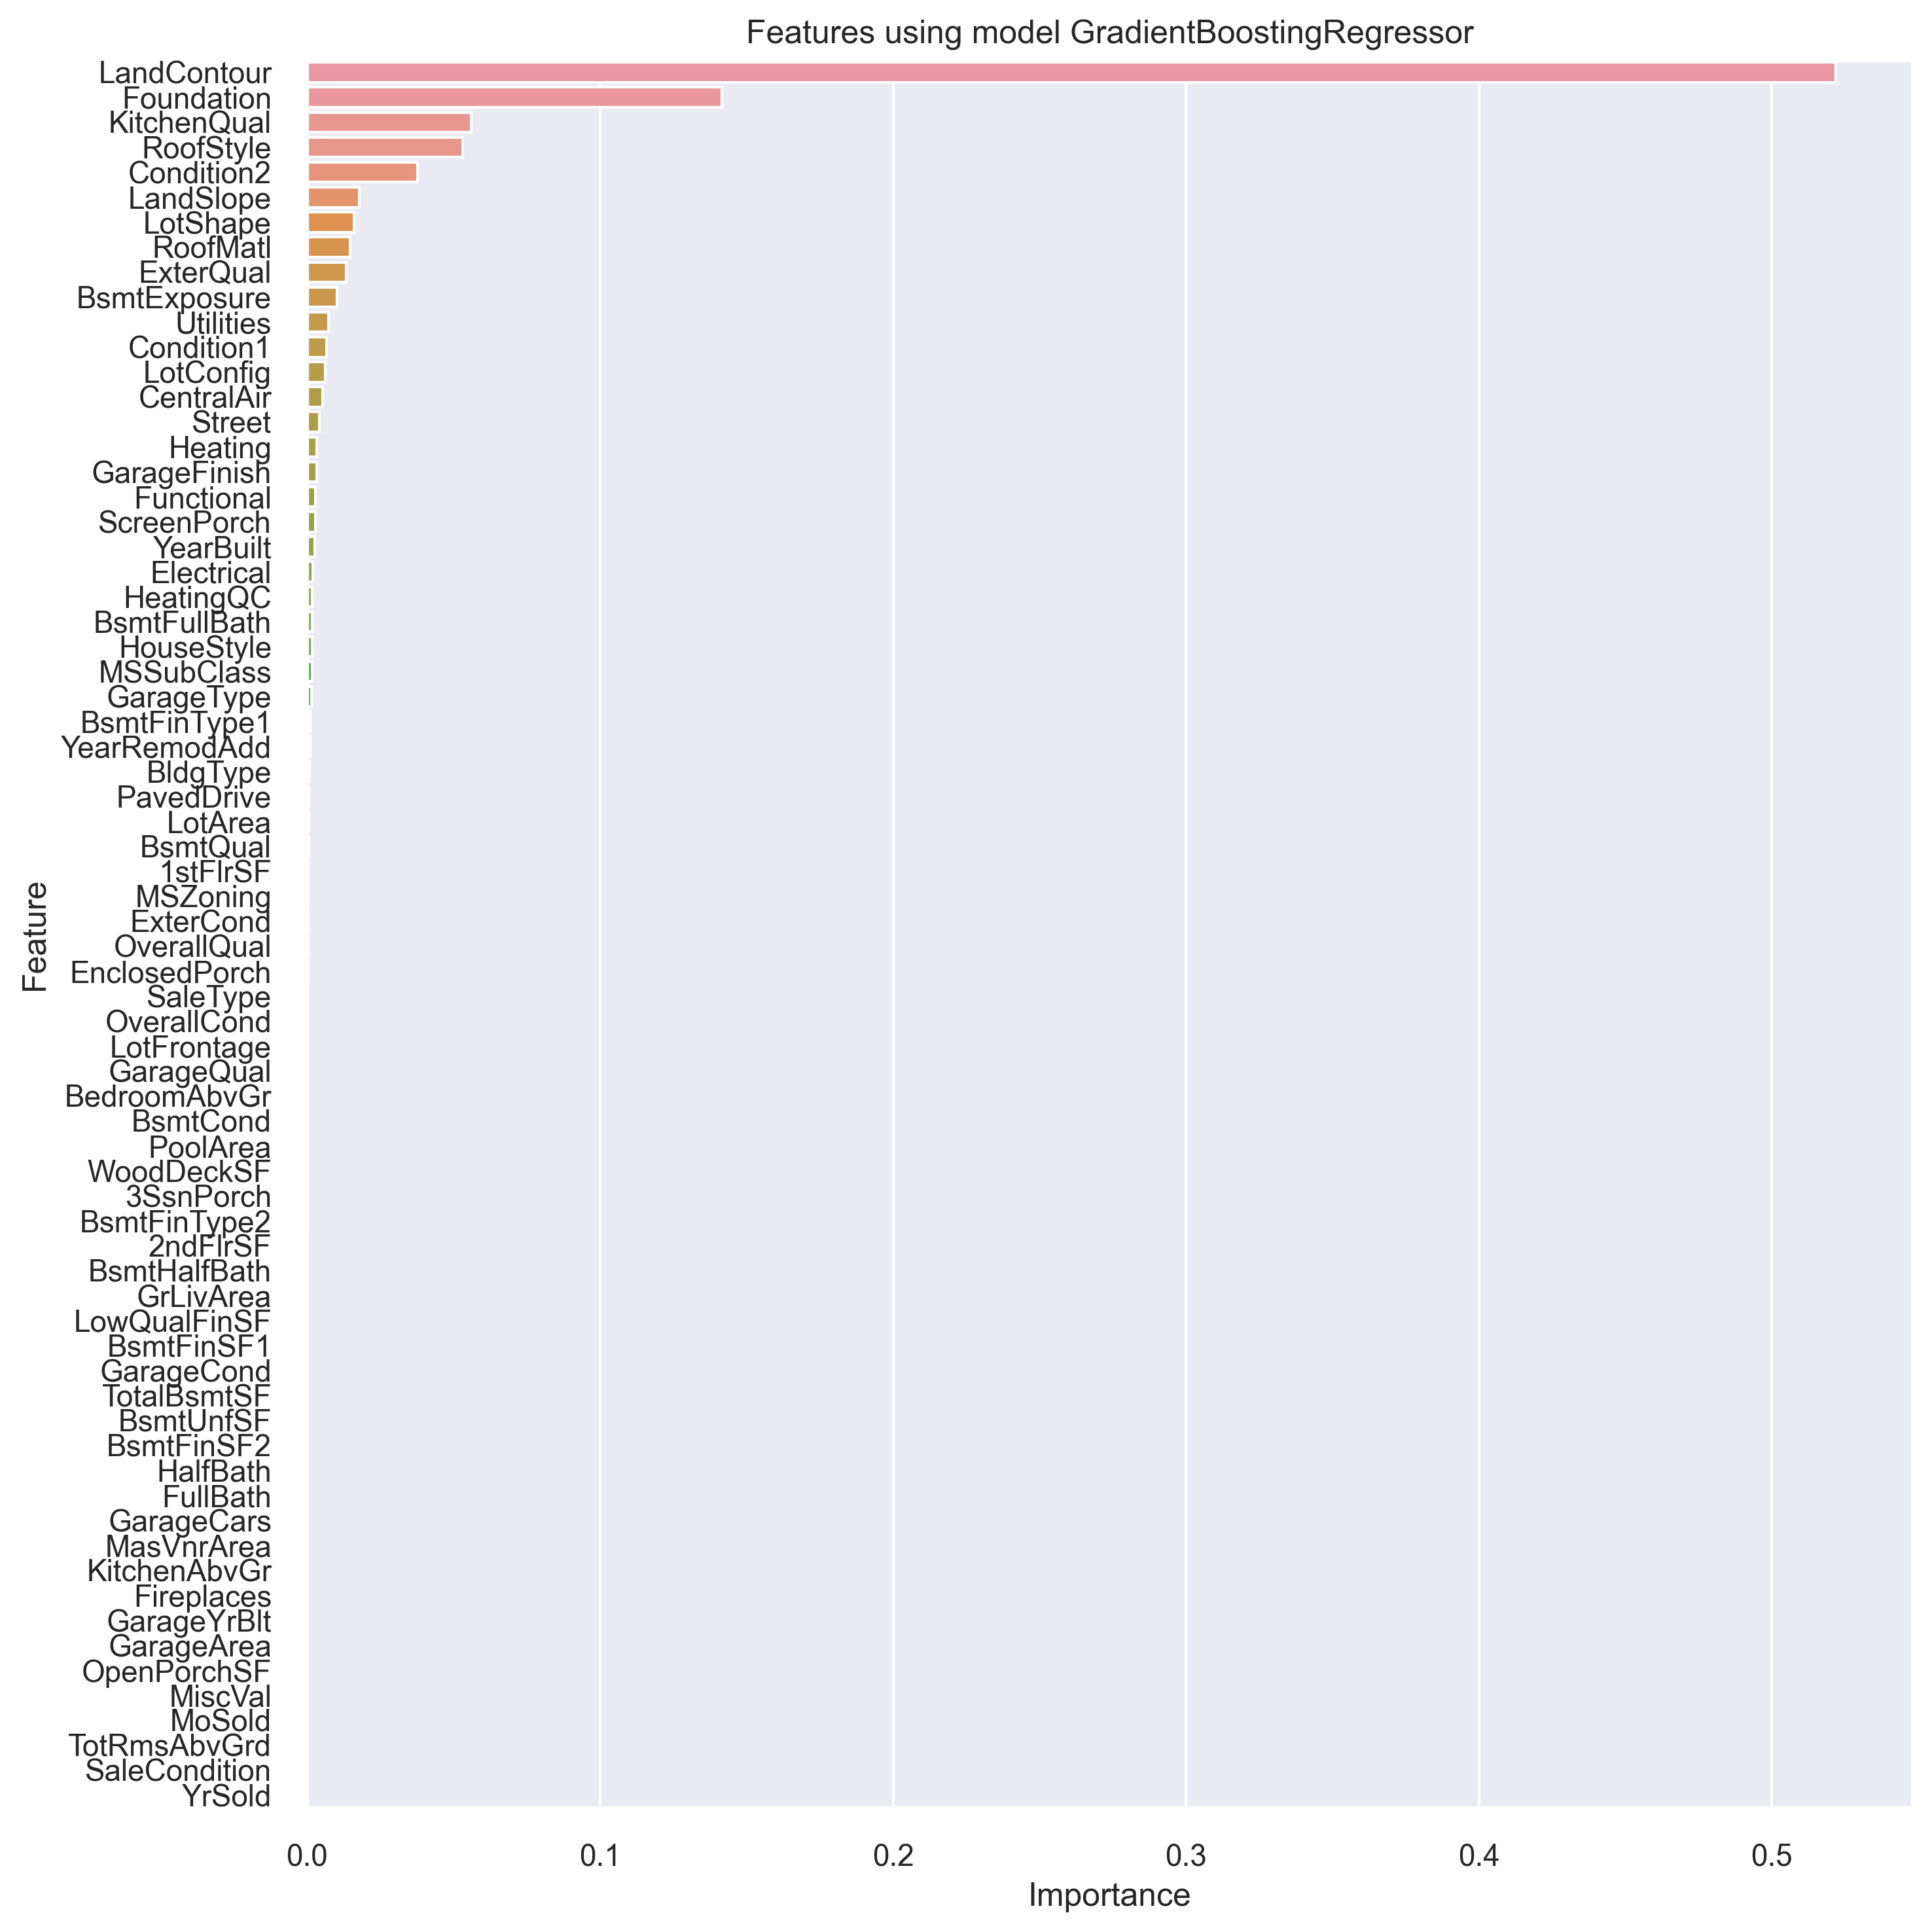

In [170]:
from sklearn.inspection import permutation_importance

def plot_importance_pipeline(model, X_train, y_train, num=None, save=False):
    clf = final_model[-1]
    feature_importances = clf.feature_importances_
    feature_names = X_train.columns.tolist() 

    data = list(zip(feature_names, feature_importances))
    feature_imp = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Importance", y="Feature", data=feature_imp.sort_values(by="Importance",
                                                                    ascending=False)[:num])

    
    plt.title(f'Features using model {type(final_model[-1]).__name__}')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
    
plot_importance_pipeline(final_model, X_train, y_train)
